In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from results_data import all_results, results
import warnings

warnings.filterwarnings("ignore")

In [133]:
ielts_data = pd.read_excel('ielts_scores.xlsx', index_col=0)

In [134]:
#results data 
all_results = all_results
results = results

#print(len(all_results))

In [135]:
ielts_overview = pd.DataFrame({"Listening":ielts_data.listening_ielts.value_counts(), "Reading": ielts_data.reading_ielts.value_counts(), "Writing": ielts_data.writing_ielts.value_counts(), "Speaking": ielts_data.speaking_ielts.value_counts(), "Overall": ielts_data.overall_ielts.value_counts()}, dtype="int").reset_index()
ielts_overview.rename({"index": "IELTS Score"}, axis=1, inplace=True)
ielts_overview = ielts_overview[ielts_overview["IELTS Score"] <=9.0].set_index("IELTS Score")

ielts_overview.to_excel("IELTS overview.xlsx")


In [136]:
#calculate total scores for skills
all_results["listening_total"] = all_results["EX1 Listening"]
all_results["reading_total"] = ((all_results["EX3 Reading"] * 0.6) + (all_results["CW1"] * 0.4))
all_results["writing_total"] = ((all_results["EX3 Writing"] * 0.4) + (all_results["CW3"] * 0.6))
all_results["speaking_total"] = ((all_results["EX2 Speaking"] * 0.5) + (all_results["CW2"] * 0.5))
all_results["overall_total"] = ((all_results["listening_total"] + all_results["reading_total"] + all_results["writing_total"] + all_results["speaking_total"])/4)

#totals df
totals = all_results[["Full Name", "cohort", "programme", "reg_group", "listening_total", "reading_total", "writing_total", "speaking_total", "overall_total"]]

In [137]:
#convert scores to ielts equivalents
def ielts_convertor(row):
  if row >= 95:
    val = 9.0
  elif row >= 90:
    val = 8.5
  elif row >= 85:
    val = 8.0
  elif row >= 80:
    val = 7.5
  elif row >= 70:
    val = 7.0
  elif row >= 60:
    val = 6.5
  elif row >= 50:
    val = 6.0
  elif row >= 40:
    val = 5.5
  elif row >= 30:
    val = 5.0
  else:
    val = 4.5
  return val

totals["listening_total"] = totals["listening_total"].apply(ielts_convertor)
totals["reading_total"] = totals["reading_total"].apply(ielts_convertor)
totals["writing_total"] = totals["writing_total"].apply(ielts_convertor)
totals["speaking_total"] = totals["speaking_total"].apply(ielts_convertor)
totals["overall_total"] = totals["overall_total"].apply(ielts_convertor)



In [138]:
#remove non-ielts scores
ielts_data = ielts_data[~(ielts_data.overall_ielts > 9.0)]



In [139]:
#combine with IELTS data
all_data = totals.join(ielts_data, how="left")

all_data.dropna(how="any", inplace=True)



In [140]:
#add nationalities data
nationalities = pd.read_excel("nationalities.xlsx")


In [141]:
#combine nationalities with IELTS data

ielts_melt_data = all_data[["Full Name", "reg_group", "listening_ielts", "reading_ielts", "writing_ielts", "speaking_ielts", "overall_ielts"]].reset_index(drop=False)

ielts_melt_data = pd.merge(ielts_melt_data, nationalities, left_on="Student ID", right_on="student_id")
ielts_melt_data.drop(columns=["student_id"], inplace=True)

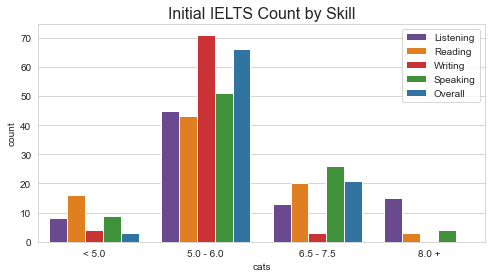

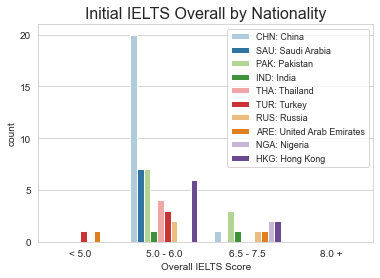

In [142]:
#plot ielts results
ielts_melt = pd.melt(ielts_melt_data, id_vars=["Student ID", "Full Name", "First Nationality", "reg_group"], var_name="IELTS Skill", value_name="Band Score")

bins = pd.IntervalIndex.from_tuples([(0, 4.5), (5.0, 6), (6.5, 7.5), (8.0, 9.0)])

ielts_melt['cats'] = pd.cut(ielts_melt["Band Score"], bins)


fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x="cats", data=ielts_melt, hue="IELTS Skill", palette="Paired_r", ax=ax)
#sns.histplot(ielts_melt, x="Band Score", hue="IELTS Skill", multiple="dodge")
ax.set_title("Initial IELTS Count by Skill", fontsize=16)
ax.set_xticklabels(["< 5.0", "5.0 - 6.0", "6.5 - 7.5", "8.0 +"])
plt.legend(["Listening", "Reading", "Writing", "Speaking", "Overall"], loc="upper right")

plt.show()
plt.clf()

country_melt = ielts_melt[((ielts_melt["First Nationality"] == "CHN: China") | (ielts_melt["First Nationality"] == "HKG: Hong Kong") | (ielts_melt["First Nationality"] == "SAU: Saudi Arabia") | (ielts_melt["First Nationality"] == "PAK: Pakistan") | (ielts_melt["First Nationality"] == "RUS: Russia") | (ielts_melt["First Nationality"] == "TUR: Turkey") | (ielts_melt["First Nationality"] == "ARE: United Arab Emirates") | (ielts_melt["First Nationality"] == "THA: Thailand") | (ielts_melt["First Nationality"] == "IND: India") | (ielts_melt["First Nationality"] == "NGA: Nigeria")) & (ielts_melt["IELTS Skill"] == "overall_ielts")]



#overall data

sns.countplot(x="cats", data=country_melt, hue="First Nationality", palette="Paired", dodge=True)
plt.legend(loc="upper right")
plt.xticks(ticks=[0,1,2,3], labels=["< 5.0", "5.0 - 6.0", "6.5 - 7.5", "8.0 +"])
plt.yticks(ticks=[x for x in range(0, 21, 5)])
plt.legend(ncol=1, fontsize=9, loc="upper right")
plt.title("Initial IELTS Overall by Nationality", fontsize=16)
plt.xlabel("Overall IELTS Score")


plt.show()


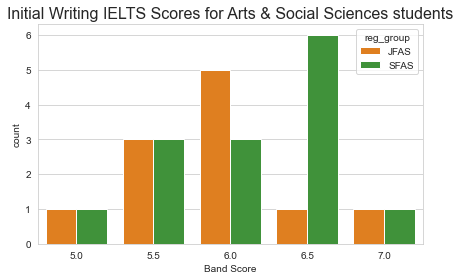

In [143]:
#ielts scores by pathway

sns.countplot(x="Band Score", hue="reg_group", data=ielts_melt[(ielts_melt["IELTS Skill"] == "writing_ielts") & ((ielts_melt["reg_group"] == "JFAS") | (ielts_melt["reg_group"] == "SFAS"))], palette="Paired_r")
plt.title("Initial Writing IELTS Scores for Arts & Social Sciences students", fontsize=16)
plt.tight_layout()
plt.savefig("charts/initial IELTS writing.png")
plt.show()

In [144]:
#calculate percentage change from ielts score
def band_change(colA, colB):
  band_improvement = colA - colB
  return band_improvement

all_data["listening_change"] = band_change(all_data["listening_total"], all_data["listening_ielts"])

all_data["reading_change"] = band_change(all_data["reading_total"], all_data["reading_ielts"])

all_data["writing_change"] = band_change(all_data["writing_total"], all_data["writing_ielts"])

all_data["speaking_change"] = band_change(all_data["speaking_total"], all_data["speaking_ielts"])

all_data["overall_change"] = band_change(all_data["overall_total"], all_data["overall_ielts"])


In [145]:
#reset index
all_data["student_id"] = all_data.index
all_data = all_data.reset_index(drop=True)
print(len(all_data))

129


In [146]:
#add col to say if improved or not
def better_or_worse(row):
  if row > 0:
    val = "gain"
  elif row == 0:
    val = "no change"
  else:
    val = "loss"
  return val

all_data["listening_status"] = all_data.listening_change.apply(better_or_worse)
all_data["reading_status"] = all_data.reading_change.apply(better_or_worse)
all_data["writing_status"] = all_data.writing_change.apply(better_or_worse)
all_data["speaking_status"] = all_data.speaking_change.apply(better_or_worse)
all_data["overall_status"] = all_data.overall_change.apply(better_or_worse)
  

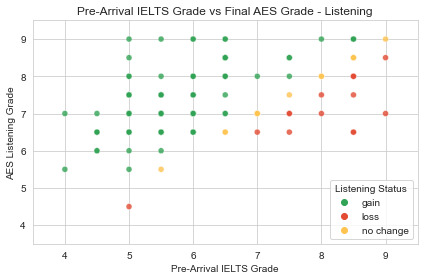

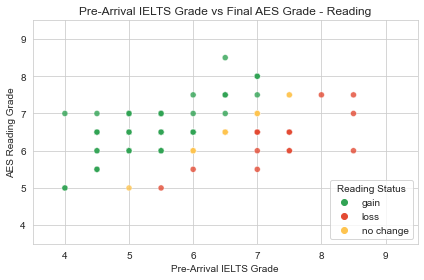

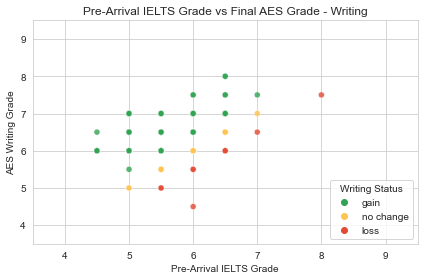

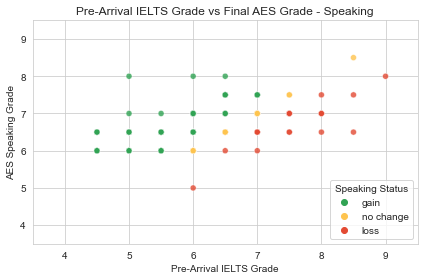

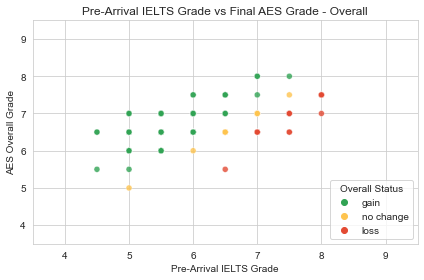

In [147]:
#sort improvers and regressors

#fig, axs = plt.subplots(1, 5, figsize=(21,6))
palette ={"gain": "#31a354", "no change": "#fec44f", "loss": "#e34a33"}
sns.set_style("whitegrid")


def plot_scatter(skills):
  i = 0
  for skill in skills:
    fig, axs = plt.subplots(1, figsize=(6,4))
    sns.scatterplot(y="{}_total".format(skill), x= "{}_ielts".format(skill), hue="{}_status".format(skill), data=all_data, palette=palette, alpha=0.8)
    axs.set_ylabel("AES {} Grade".format(skill.capitalize()))
    axs.set_xlabel("Pre-Arrival IELTS Grade")
    axs.set_xlim(3.5, 9.5)
    axs.set_ylim(3.5, 9.5)
    axs.set_title("Pre-Arrival IELTS Grade vs Final AES Grade - {}".format(skill.capitalize()))
    axs.legend(title="{} Status".format(skill.capitalize()), loc="lower right")
    plt.tight_layout()
    plt.savefig("charts/IELTS vs AES - {}".format(skill))
    plt.show()
    i += 1

plot_scatter(["listening", "reading", "writing", "speaking", "overall"])



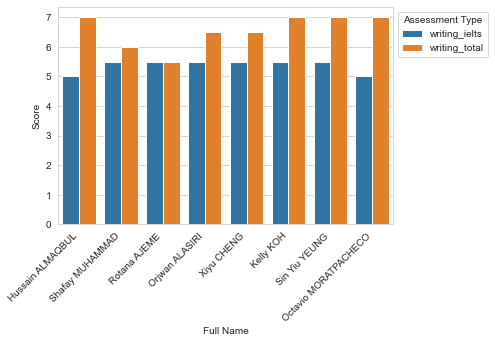

In [178]:
#IELTS entry for SFAS & JFAS students and results

arts_students = all_data[(all_data["reg_group"] == "SFAS") | (all_data["reg_group"] == "JFAS")]

arts_students_low_writing = arts_students[arts_students["writing_ielts"] <= 5.5].reset_index(drop=True)

arts_students_low_writing["arts_cats"] = pd.cut(arts_students_low_writing["writing_total"], bins=[0,7,7,9], right=False, duplicates="drop", labels=["didn't make required improvement", "made required improvement"])

#print(arts_students_low_writing.columns)
melted = pd.melt(arts_students_low_writing[["Full Name", "writing_ielts", "writing_total"]], id_vars=["Full Name"], var_name="Assessment", value_name="Score")
sns.barplot(data=melted, x="Full Name", y="Score", hue="Assessment")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1,1), title="Assessment Type")
plt.show()

       Skill  Average Gain  Average Loss  Net Change
0  Listening          1.60         -0.90        0.70
1    Reading          1.26         -1.00        0.26
2    Writing          0.98         -0.60        0.38
3   Speaking          1.07         -0.79        0.28
4    Overall          1.01         -0.61        0.40


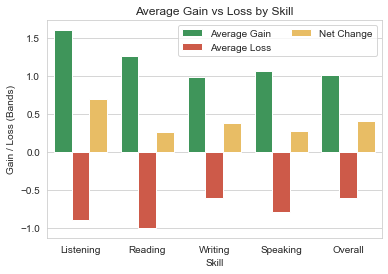

In [149]:
#average gains and losses
def get_averages(series, status_col, status):
  avg = round(all_data[series][all_data[status_col] == status].mean(), 2)
  return avg



#averages df
averages_data = {"Skill": ["Listening", "Reading", "Writing", "Speaking", "Overall"], "Average Gain": [get_averages("listening_change", "listening_status", "gain"), get_averages("reading_change", "reading_status", "gain"), get_averages("writing_change", "writing_status", "gain"), get_averages("speaking_change", "speaking_status", "gain"), get_averages("overall_change", "overall_status", "gain")], "Average Loss": [get_averages("listening_change", "listening_status", "loss"), get_averages("reading_change", "reading_status", "loss"), get_averages("writing_change", "writing_status", "loss"), get_averages("speaking_change", "speaking_status", "loss"), get_averages("overall_change", "overall_status", "loss")]}

averages_df = pd.DataFrame(averages_data)

averages_df["Net Change"] = averages_df["Average Gain"] + averages_df["Average Loss"]
print(averages_df)

#melt
averages_melt = pd.melt(averages_df, id_vars="Skill", var_name="Type", value_name="Gain/Loss")

#plot gain vs loss
fig, axs = plt.subplots(1,figsize=(6,4))
gain_loss_palette = {"Average Gain": "#31a354", "Average Loss": "#e34a33", "Net Change": "#fec44f"}
plt.title("Average Gain vs Loss by Skill")
sns.barplot(x="Skill", y="Gain/Loss", hue="Type", data=averages_melt, palette=gain_loss_palette, ax=axs)
axs.set_ylabel("Gain / Loss (Bands)")
axs.legend(ncol=2)
plt.savefig("charts/average gain-loss IELTS.png")
plt.show()

In [150]:
#status df
data = {"Listening": all_data.listening_status.value_counts(), "Reading": all_data.reading_status.value_counts(), "Writing": all_data.writing_status.value_counts(), "Speaking": all_data.speaking_status.value_counts(), "Overall": all_data.overall_status.value_counts()}
status_df = pd.DataFrame(data)

#student statuses
student_status_df = all_data[["student_id", "Full Name", "cohort", "programme", "listening_ielts", "listening_change", "reading_ielts", "reading_change", "writing_ielts", "writing_change", "speaking_ielts", "speaking_change", "overall_ielts", "overall_change"]]

student_status_df.set_index("student_id", drop=True, inplace=True)

student_status_df.rename({"listening_ielts": "Initial Listening IELTS", "listening_change": "Listening Band Change", "reading_ielts": "Initial Reading IELTS", "reading_change": "Reading Band Change", "writing_ielts": "Initial Writing IELTS", "writing_change": "Writing Band Change", "speaking_ielts": "Initial Speaking IELTS", "speaking_change": "Speaking Band Change", "overall_ielts": "Initial Overall IELTS", "overall_change": "Overall Band Change"}, axis=1, inplace=True)


In [151]:
writer = pd.ExcelWriter("Student Improvement Status.xlsx", engine='xlsxwriter')

status_df.to_excel(writer, sheet_name='Gain-Loss Overview')
student_status_df.to_excel(writer, sheet_name='Breakdown by Student')

workbook = writer.book
worksheet1 = writer.sheets["Gain-Loss Overview"]
worksheet2 = writer.sheets["Breakdown by Student"]
worksheet3 = workbook.add_worksheet("Charts")

#add gain-loss overview table
(max_row_1, max_col_1) = status_df.shape
column_settings_1 = [{"header": column} for column in status_df.columns]
col1_1 = column_settings_1.insert(0, {"header": "Status"})


worksheet1.add_table(0,0, max_row_1, max_col_1, {"columns": column_settings_1, "style": "Table Style Light 8"})
worksheet1.set_column(0, max_col_1, 20)

#add student data table
(max_row, max_col) = student_status_df.shape
column_settings = [{"header": column} for column in student_status_df.columns]
col1 = column_settings.insert(0, {"header": "Student ID"})
#print(column_settings)

worksheet2.add_table(0,0, max_row, max_col, {'columns': column_settings, "style": 'Table Style Light 8'})
worksheet2.set_column(0, max_col, 20)

worksheet2.conditional_format("F2:F{}".format(max_row +1), {"type": '3_color_scale'})
worksheet2.conditional_format("H2:H{}".format(max_row +1), {"type": '3_color_scale'})
worksheet2.conditional_format("J2:J{}".format(max_row +1), {"type": '3_color_scale'})
worksheet2.conditional_format("L2:L{}".format(max_row +1), {"type": '3_color_scale'})
worksheet2.conditional_format("N2:N{}".format(max_row +1), {"type": '3_color_scale'})

worksheet3.insert_image("A1", "charts/IELTS vs AES - Listening.png")
worksheet3.insert_image("J1", "charts/IELTS vs AES - Reading.png")
worksheet3.insert_image("A21", "charts/IELTS vs AES - Writing.png")
worksheet3.insert_image("J21", "charts/IELTS vs AES - Speaking.png")
worksheet3.insert_image("S1", "charts/average gain-loss IELTS.png")




writer.save()
